# HW 3 - Beer Markets

In this post, we will be exploring beer pricing by analyzing the DataFrame "Beer Markets". This DataFrame contains information about beer purchase details and household characteristics. We will analyze how these factors, such as household size, type of beer container, and household income impact the price of beer (per fluid ounce).

## Loading Packages and Settings

In [1]:
import pandas as pd
import numpy as np
from tabulate import tabulate  # for table summary
import scipy.stats as stats
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm  # for lowess smoothing

from pyspark.sql import SparkSession
from pyspark.sql.functions import rand, col, pow, mean, avg, when, log, sqrt, exp
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression, GeneralizedLinearRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

spark = SparkSession.builder.master("local[*]").getOrCreate()

## UDFs

We will be using a variety of User Defined Functions (UDFs) in order to perform functions necessary for our Linear Regression Models. We will define our UDFs before we begin.

In [10]:
def add_dummy_variables(var_name, reference_level, category_order=None):
    """
    Creates dummy variables for the specified column in the global DataFrames dtrain and dtest.
    Allows manual setting of category order.

    Parameters:
        var_name (str): The name of the categorical column (e.g., "borough_name").
        reference_level (int): Index of the category to be used as the reference (dummy omitted).
        category_order (list, optional): List of categories in the desired order. If None, categories are sorted.

    Returns:
        dummy_cols (list): List of dummy column names excluding the reference category.
        ref_category (str): The category chosen as the reference.
    """
    global dtrain, dtest

    # Get distinct categories from the training set.
    categories = dtrain.select(var_name).distinct().rdd.flatMap(lambda x: x).collect()

    # Convert booleans to strings if present.
    categories = [str(c) if isinstance(c, bool) else c for c in categories]

    # Use manual category order if provided; otherwise, sort categories.
    if category_order:
        # Ensure all categories are present in the user-defined order
        missing = set(categories) - set(category_order)
        if missing:
            raise ValueError(f"These categories are missing from your custom order: {missing}")
        categories = category_order
    else:
        categories = sorted(categories)

    # Validate reference_level
    if reference_level < 0 or reference_level >= len(categories):
        raise ValueError(f"reference_level must be between 0 and {len(categories) - 1}")

    # Define the reference category
    ref_category = categories[reference_level]
    print("Reference category (dummy omitted):", ref_category)

    # Create dummy variables for all categories
    for cat in categories:
        dummy_col_name = var_name + "_" + str(cat).replace(" ", "_")
        dtrain = dtrain.withColumn(dummy_col_name, when(col(var_name) == cat, 1).otherwise(0))
        dtest = dtest.withColumn(dummy_col_name, when(col(var_name) == cat, 1).otherwise(0))

    # List of dummy columns, excluding the reference category
    dummy_cols = [var_name + "_" + str(cat).replace(" ", "_") for cat in categories if cat != ref_category]

    return dummy_cols, ref_category


# Example usage without category_order:
# dummy_cols_year, ref_category_year = add_dummy_variables('year', 0)

# Example usage with category_order:
# custom_order_wkday = ['sunday', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday']
# dummy_cols_wkday, ref_category_wkday = add_dummy_variables('wkday', reference_level=0, category_order = custom_order_wkday)


In [9]:
def regression_table(model, assembler):
    """
    Creates a formatted regression table from a fitted LinearRegression model and its VectorAssembler,
    and inserts a dashed horizontal line after the Intercept row. The table includes separate columns
    for the 95% confidence interval lower and upper bounds for each coefficient (computed at the 5% significance level)
    and an "Observations" row (using model.summary.numInstances) above the R² row.
    The RMSE row is placed as the last row.

    The columns are ordered as:
        Metric | Value | Significance | Std. Error | p-value | 95% CI Lower | 95% CI Upper

    For the "Value", "Std. Error", "95% CI Lower", and "95% CI Upper" columns, commas are inserted every three digits,
    with 3 decimal places (except for Observations which is formatted as an integer with commas).

    Parameters:
        model: A fitted LinearRegression model (with a .summary attribute).
        assembler: The VectorAssembler used to assemble the features for the model.

    Returns:
        A formatted string containing the regression table.
    """
    # Extract coefficients and standard errors as NumPy arrays
    coeffs = model.coefficients.toArray()

    std_errors_all = np.array(model.summary.coefficientStandardErrors)

    # Check if the intercept's standard error is included (one extra element)
    if len(std_errors_all) == len(coeffs) + 1:
        intercept_se = std_errors_all[0]
        std_errors = std_errors_all[1:]
    else:
        intercept_se = None
        std_errors = std_errors_all

    # Compute t-statistics for feature coefficients (t = beta / SE(beta))
    # t_stats = coeffs / std_errors
    t_stats = model.summary.tValues

    # Degrees of freedom: number of instances minus number of predictors minus 1 (for intercept)
    df = model.summary.numInstances - len(coeffs) - 1

    # Compute the t-critical value for a 95% confidence interval (two-tailed, 5% significance)
    t_critical = stats.t.ppf(0.975, df)

    # Compute two-tailed p-values for each feature coefficient
    # p_values = [2 * (1 - stats.t.cdf(np.abs(t), df)) for t in t_stats]
    p_values = model.summary.pValues

    # Function to assign significance stars based on p-value
    def significance_stars(p):
        if p < 0.01:
            return "***"
        elif p < 0.05:
            return "**"
        elif p < 0.1:
            return "*"
        else:
            return ""

    # Build the table rows.
    # Order: Metric, Value, Significance, Std. Error, p-value, 95% CI Lower, 95% CI Upper.
    table = []
    for feature, beta, se, p in zip(assembler.getInputCols(), coeffs, std_errors, p_values):
        ci_lower = beta - t_critical * se
        ci_upper = beta + t_critical * se
        table.append([
            "Beta: " + feature,       # Metric name
            beta,                     # Beta estimate (Value)
            significance_stars(p),    # Significance stars
            se,                       # Standard error
            p,                        # p-value
            ci_lower,                 # 95% CI lower bound
            ci_upper                  # 95% CI upper bound
        ])

    # Compute and add the intercept row with its SE, p-value, significance, and CI (if available)
    if intercept_se is not None:
        intercept_t = model.intercept / intercept_se
        intercept_p = 2 * (1 - stats.t.cdf(np.abs(intercept_t), df))
        intercept_sig = significance_stars(intercept_p)
        ci_intercept_lower = model.intercept - t_critical * intercept_se
        ci_intercept_upper = model.intercept + t_critical * intercept_se
    else:
        intercept_se = ""
        intercept_p = ""
        intercept_sig = ""
        ci_intercept_lower = ""
        ci_intercept_upper = ""

    table.append([
        "Intercept",
        model.intercept,
        intercept_sig,
        intercept_se,
        intercept_p,
        ci_intercept_lower,
        ci_intercept_upper
    ])

    # Append overall model metrics:
    # Insert an Observations row using model.summary.numInstances,
    # then an R² row, and finally the RMSE row as the last row.
    table.append(["Observations", model.summary.numInstances, "", "", "", "", ""])
    table.append(["R²", model.summary.r2, "", "", "", "", ""])
    table.append(["RMSE", model.summary.rootMeanSquaredError, "", "", "", "", ""])

    # Format the table.
    # For the "Value" (index 1), "Std. Error" (index 3), "95% CI Lower" (index 5), and "95% CI Upper" (index 6) columns,
    # format with commas and 3 decimal places, except for Observations which should be an integer with commas.
    # For the p-value (index 4), format to 3 decimal places.
    formatted_table = []
    for row in table:
        formatted_row = []
        for i, item in enumerate(row):
            if row[0] == "Observations" and i == 1 and isinstance(item, (int, float, np.floating)) and item != "":
                # Format Observations as integer with commas, no decimals.
                formatted_row.append(f"{int(item):,}")
            elif isinstance(item, (int, float, np.floating)) and item != "":
                if i in [1, 3, 5, 6]:
                    formatted_row.append(f"{item:,.3f}")
                elif i == 4:
                    formatted_row.append(f"{item:.3f}")
                else:
                    formatted_row.append(f"{item:.3f}")
            else:
                formatted_row.append(item)
        formatted_table.append(formatted_row)

    # Generate the table string using tabulate.
    table_str = tabulate(
        formatted_table,
        headers=["Metric", "Value", "Sig.", "Std. Error", "p-value", "95% CI Lower", "95% CI Upper"],
        tablefmt="pretty",
        colalign=("left", "right", "center", "right", "right", "right", "right")
    )

    # Insert a dashed line after the Intercept row for clarity.
    lines = table_str.split("\n")
    dash_line = '-' * len(lines[0])
    for i, line in enumerate(lines):
        if "Intercept" in line and not line.strip().startswith('+'):
            lines.insert(i+1, dash_line)
            break

    return "\n".join(lines)

In [16]:
def add_interaction_terms(var_list1, var_list2, var_list3=None):
    """
    Creates interaction term columns in the global DataFrames dtrain and dtest.

    For two sets of variable names (which may represent categorical (dummy) or continuous variables),
    this function creates two-way interactions by multiplying each variable in var_list1 with each
    variable in var_list2.

    Optionally, if a third list of variable names (var_list3) is provided, the function also creates
    three-way interactions among each variable in var_list1, each variable in var_list2, and each variable
    in var_list3.

    Parameters:
        var_list1 (list): List of column names for the first set of variables.
        var_list2 (list): List of column names for the second set of variables.
        var_list3 (list, optional): List of column names for the third set of variables for three-way interactions.

    Returns:
        A flat list of new interaction column names.
    """
    global dtrain, dtest

    interaction_cols = []

    # Create two-way interactions between var_list1 and var_list2.
    for var1 in var_list1:
        for var2 in var_list2:
            col_name = f"{var1}_*_{var2}"
            dtrain = dtrain.withColumn(col_name, col(var1).cast("double") * col(var2).cast("double"))
            dtest = dtest.withColumn(col_name, col(var1).cast("double") * col(var2).cast("double"))
            interaction_cols.append(col_name)

    # Create two-way interactions between var_list1 and var_list3.
    if var_list3 is not None:
      for var1 in var_list1:
          for var3 in var_list3:
              col_name = f"{var1}_*_{var3}"
              dtrain = dtrain.withColumn(col_name, col(var1).cast("double") * col(var3).cast("double"))
              dtest = dtest.withColumn(col_name, col(var1).cast("double") * col(var3).cast("double"))
              interaction_cols.append(col_name)

    # Create two-way interactions between var_list2 and var_list3.
    if var_list3 is not None:
      for var2 in var_list2:
          for var3 in var_list3:
              col_name = f"{var2}_*_{var3}"
              dtrain = dtrain.withColumn(col_name, col(var2).cast("double") * col(var3).cast("double"))
              dtest = dtest.withColumn(col_name, col(var2).cast("double") * col(var3).cast("double"))
              interaction_cols.append(col_name)

    # If a third list is provided, create three-way interactions.
    if var_list3 is not None:
        for var1 in var_list1:
            for var2 in var_list2:
                for var3 in var_list3:
                    col_name = f"{var1}_*_{var2}_*_{var3}"
                    dtrain = dtrain.withColumn(col_name, col(var1).cast("double") * col(var2).cast("double") * col(var3).cast("double"))
                    dtest = dtest.withColumn(col_name, col(var1).cast("double") * col(var2).cast("double") * col(var3).cast("double"))
                    interaction_cols.append(col_name)

    return interaction_cols

 # Example
 # interaction_cols_brand_price = add_interaction_terms(dummy_cols_brand, ['log_price'])
 # interaction_cols_brand_ad_price = add_interaction_terms(dummy_cols_brand, dummy_cols_ad, ['log_price'])

## Loading DataFrame - Beer Markets

In [3]:
beer_markets = pd.read_csv(
  'https://bcdanl.github.io/data/beer_markets_all_cleaned.csv'
)

## Filtering DataFrame

We will be focusing on observations that are either a can or non-refillable bottle in the beer_markets DataFrame. Additionally, we will be using the log of beer volume as one of our predictors.

In [4]:
beer_df = beer_markets.loc[
  (beer_markets['container'] == 'CAN') | (beer_markets['container'] == 'NON REFILLABLE BOTTLE')
]

beer_df

,household,X_purchase_desc,quantity,brand,dollar_spent,beer_floz,price_floz,container,promo,region,...,age,employment,degree,occupation,ethnic,microwave,dishwasher,tvcable,singlefamilyhome,npeople
0,2000946,BUD LT BR CN 12P,1,BUD_LIGHT,8.14,144.0,0.056528,CAN,False,CENTRAL,...,50+,none,Grad,none/retired/student,white,True,True,premium,False,1
1,2003036,BUD LT BR CN 24P,1,BUD_LIGHT,17.48,288.0,0.060694,CAN,False,SOUTH,...,50+,full,College,clerical/sales/service,white,True,True,basic,True,2
2,2003036,BUD LT BR CN 24P,2,BUD_LIGHT,33.92,576.0,0.058889,CAN,False,SOUTH,...,50+,full,College,clerical/sales/service,white,True,True,basic,True,2
3,2003036,BUD LT BR CN 30P,2,BUD_LIGHT,34.74,720.0,0.048250,CAN,False,SOUTH,...,50+,full,College,clerical/sales/service,white,True,True,basic,True,2
4,2003036,BUD LT BR CN 36P,2,BUD_LIGHT,40.48,864.0,0.046852,CAN,False,SOUTH,...,50+,full,College,clerical/sales/service,white,True,True,basic,True,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73110,9158319,NATURAL LT BR CN 24P,1,NATURAL_LIGHT,11.49,288.0,0.039896,CAN,True,SOUTH,...,50+,none,HS,none/retired/student,black,True,True,premium,True,2
73111,9158319,NATURAL LT BR CN 24P,1,NATURAL_LIGHT,9.97,288.0,0.034618,CAN,False,SOUTH,...,50+,none,HS,none/retired/student,black,True,True,premium,True,2
73112,9158319,NATURAL LT BR CN 24P,1,NATURAL_LIGHT,9.98,288.0,0.034653,CAN,False,SOUTH,...,50+,none,HS,none/retired/student,black,True,True,premium,True,2
73113,9164033,NATURAL LT BR CN 30P,1,NATURAL_LIGHT,12.98,360.0,0.036056,CAN,False,WEST,...,50+,full,College,prof,hispanic,True,True,basic,True,5plus


In [5]:
df = spark.createDataFrame(beer_df)

In [6]:
df = df.withColumn('log_beer_floz', log('beer_floz'))

In [7]:
df = df.withColumn('log_price_floz', log('price_floz'))

## Split into Training and Test DataFrames

First, we will split our data into training and test DataFrames. 67% of observations will belong to the training DataFrame and the remaining 33% will go to the test DataFrame.

In [8]:
dtrain, dtest = df.randomSplit([.67, .33], seed = 1234)

## Overview of Linear Regression Models

For the beer_markets DataFrame, we will consider and compare three different Linear Regression models. In Model 1, there are three independent or predictor variables: dummy variables for different beer markets, a dummy variable for whether or not the container is a can, and the log of the volume of beer in fluid ounces. Model 2 has the same independent variables as Model 1 in addition to the interaction term between different beer brands and the log of beer volume. Model 3 has the same independent variables as Model 2 in addition to three more interaction terms: whether or not promotion was used and the log of beer volume, brand and promotion usage, and brand, promotion usage, and the log of beer volume. For Models 2 and 3, the interaction terms show us how the relationship between one predictor and the outcome variable changes as the value of another predictor changes. For all three models, the dependent or outcome variable is the log of price per fluid ounce of beer. Using linear regression, we can predict the log price per fluid ounce based on the independent variables given in the model.

## Training the Models

Before we begin training our models, we must add dummy variables for our categorical variables. To do this, we will apply our UDF for adding dummy variables. All observations must be numerical in order to train the Linear Regression Model.

In [11]:
dummy_cols_brand, ref_category_brand = add_dummy_variables('brand', 0, category_order=None)
dummy_cols_market, ref_category_market = add_dummy_variables('market', 5, category_order=None)
dummy_cols_container, ref_category_container = add_dummy_variables('container', 0, category_order=None)

Reference category (dummy omitted): BUD_LIGHT
Reference category (dummy omitted): BUFFALO-ROCHESTER
Reference category (dummy omitted): CAN


### Model 1

In [12]:
x_cols_1 = ['log_beer_floz']

assembler_predictors_1 = (
    x_cols_1 +
    dummy_cols_brand + dummy_cols_market + dummy_cols_container
)

In [13]:
assembler_1 = VectorAssembler(
    inputCols = assembler_predictors_1,
    outputCol = "predictors"
)

dtrain_1 = assembler_1.transform(dtrain)
dtest_1  = assembler_1.transform(dtest)

# training model
model_1 = (
        LinearRegression(featuresCol="predictors",
                                labelCol="log_price_floz")
    .fit(dtrain_1)
)

# making prediction
dtrain_1 = model_1.transform(dtrain_1)
dtest_1 = model_1.transform(dtest_1)

#### Summary

In [14]:
print(dtest_1.select(["prediction", "price_floz"]).show())

+-------------------+------------------+
|         prediction|        price_floz|
+-------------------+------------------+
| -2.792350778968452|0.0659027777777777|
| -2.864445041558655|0.0565277777777777|
|-2.8788697218373027|           0.06375|
|  -3.27220818906385|0.0392222222222222|
| -3.327091138288483|0.0388611111111111|
| -3.327091138288483|0.0388611111111111|
| -3.327091138288483|0.0415833333333333|
|-3.1275589685986342|0.0406944444444444|
| -2.766643192389631|0.0620833333333333|
|-2.7807239771704384|0.0740277777777777|
| -2.958268062960834|0.0485763888888888|
|-2.8454523724376664|0.0554861111111111|
|-2.8454523724376664|0.0763194444444444|
|-2.9003353216622996|           0.04625|
|-2.9003353216622996|           0.04625|
| -2.969479660376425|0.0444166666666666|
| -2.969479660376425|0.0471944444444444|
| -2.969479660376425|0.0471944444444444|
| -2.969479660376425|           0.05275|
| -2.890809854407121|0.0588888888888888|
+-------------------+------------------+
only showing top

In [15]:
print(regression_table(model_1, assembler_1))

+-----------------------------------+--------+------+------------+---------+--------------+--------------+
| Metric                            |  Value | Sig. | Std. Error | p-value | 95% CI Lower | 95% CI Upper |
+-----------------------------------+--------+------+------------+---------+--------------+--------------+
| Beta: log_beer_floz               | -0.135 | ***  |      0.003 |   0.000 |       -0.142 |       -0.129 |
| Beta: brand_BUSCH_LIGHT           | -0.265 | ***  |      0.003 |   0.000 |       -0.271 |       -0.259 |
| Beta: brand_COORS_LIGHT           | -0.004 |      |      0.003 |   0.224 |       -0.009 |        0.002 |
| Beta: brand_MILLER_LITE           | -0.017 | ***  |      0.003 |   0.000 |       -0.022 |       -0.011 |
| Beta: brand_NATURAL_LIGHT         | -0.320 | ***  |      0.014 |   0.000 |       -0.348 |       -0.293 |
| Beta: market_ALBANY               |  0.031 |  **  |      0.012 |   0.025 |        0.008 |        0.055 |
| Beta: market_ATLANTA              |

### Model 2

We must add one more predictor to Model 2. We will add an interaction term between beer brand and log of beer volume.

In [17]:
interaction_cols_brand_log_floz = add_interaction_terms(dummy_cols_brand, ['log_beer_floz'], var_list3=None)

In [18]:
assembler_predictors_2 = (
    x_cols_1 +
    dummy_cols_brand + dummy_cols_market + dummy_cols_container +
    interaction_cols_brand_log_floz
)

In [19]:
assembler_2 = VectorAssembler(
    inputCols = assembler_predictors_2,
    outputCol = "predictors"
)

dtrain_2 = assembler_2.transform(dtrain)
dtest_2  = assembler_2.transform(dtest)

# training model
model_2 = (
        LinearRegression(featuresCol="predictors",
                                labelCol="log_price_floz")
    .fit(dtrain_2)
)

# making prediction
dtrain_2 = model_2.transform(dtrain_2)
dtest_2 = model_2.transform(dtest_2)

#### Summary

In [20]:
print(regression_table(model_2, assembler_2))

+-------------------------------------------+--------+------+------------+---------+--------------+--------------+
| Metric                                    |  Value | Sig. | Std. Error | p-value | 95% CI Lower | 95% CI Upper |
+-------------------------------------------+--------+------+------------+---------+--------------+--------------+
| Beta: log_beer_floz                       | -0.142 | ***  |      0.027 |   0.000 |       -0.195 |       -0.090 |
| Beta: brand_BUSCH_LIGHT                   | -0.146 | ***  |      0.024 |   0.000 |       -0.192 |       -0.100 |
| Beta: brand_COORS_LIGHT                   | -0.108 | ***  |      0.022 |   0.000 |       -0.150 |       -0.065 |
| Beta: brand_MILLER_LITE                   |  0.089 | ***  |      0.022 |   0.000 |        0.046 |        0.132 |
| Beta: brand_NATURAL_LIGHT                 | -0.581 | ***  |      0.014 |   0.000 |       -0.609 |       -0.554 |
| Beta: market_ALBANY                       |  0.034 |  **  |      0.012 |   0.0

In [21]:
print(dtest_2.select(["prediction", "price_floz"]).show())

+-------------------+------------------+
|         prediction|        price_floz|
+-------------------+------------------+
|  -2.79184159063699|0.0659027777777777|
|-2.8594121622298223|0.0565277777777777|
| -2.869616423365115|           0.06375|
|-3.2968652189031418|0.0392222222222222|
|-3.3630798574977083|0.0388611111111111|
|-3.3630798574977083|0.0388611111111111|
|-3.3630798574977083|0.0415833333333333|
|-3.1358115955296135|0.0406944444444444|
| -2.760190593306609|0.0620833333333333|
|-2.7771575669310384|0.0740277777777777|
| -2.958054745817342|0.0485763888888888|
|-2.8540147644649227|0.0554861111111111|
|-2.8540147644649227|0.0763194444444444|
| -2.904018769588993|           0.04625|
| -2.904018769588993|           0.04625|
|-2.9670163656768107|0.0444166666666666|
|-2.9670163656768107|0.0471944444444444|
|-2.9670163656768107|0.0471944444444444|
|-2.9670163656768107|           0.05275|
| -2.891047126501169|0.0588888888888888|
+-------------------+------------------+
only showing top

### Model 3

Similarly to Model 2, we must add more predictors for Model 3. Here, we will add a dummy variable for promotion and several more interaction terms. We will consider the interaction between bran and beer volume, promotion and beer volume, brand and promotion, and brand, promotion, and beer volume.

In [22]:
dummy_cols_promo, ref_category_promo = add_dummy_variables('promo', 0)

Reference category (dummy omitted): False


In [23]:
interaction_cols_brand_log_floz = add_interaction_terms(dummy_cols_brand, ['log_beer_floz'], var_list3=None)
interaction_cols_promo_log_floz = add_interaction_terms(dummy_cols_promo, ['log_beer_floz'], var_list3=None)
interaction_cols_brand_promo = add_interaction_terms(dummy_cols_brand, dummy_cols_promo, var_list3=None)
interaction_cols_brand_promo_log_floz = add_interaction_terms(dummy_cols_brand, dummy_cols_promo, ['log_beer_floz'])

In [24]:
assembler_predictors_3 = (
    x_cols_1 +
    dummy_cols_brand + dummy_cols_market + dummy_cols_container +
    interaction_cols_brand_log_floz +
    interaction_cols_promo_log_floz +
    interaction_cols_brand_promo +
    interaction_cols_brand_promo_log_floz
)

In [25]:
assembler_3 = VectorAssembler(
    inputCols = assembler_predictors_3,
    outputCol = "predictors"
)

dtrain_3 = assembler_3.transform(dtrain)
dtest_3  = assembler_3.transform(dtest)

# training model
model_3 = (
        LinearRegression(featuresCol="predictors",
                                labelCol="log_price_floz")
    .fit(dtrain_3)
)

# making prediction
dtrain_3 = model_3.transform(dtrain_3)
dtest_3 = model_3.transform(dtest_3)

#### Summary

In [26]:
beta_values = model_3.coefficients.toArray()
feature_names = assembler_3.getInputCols()

beta_table = []
for i in range(len(feature_names)):
    beta_table.append([feature_names[i], beta_values[i]])

tabulate(beta_table)

'------------------------------------------------  -----------\nlog_beer_floz                                     -0.136455\nbrand_BUSCH_LIGHT                                 -0.0907828\nbrand_COORS_LIGHT                                 -0.0737586\nbrand_MILLER_LITE                                  0.133081\nbrand_NATURAL_LIGHT                               -0.475828\nmarket_ALBANY                                      0.0253785\nmarket_ATLANTA                                     0.0763817\nmarket_BALTIMORE                                   0.0933113\nmarket_BIRMINGHAM                                  0.130783\nmarket_BOSTON                                      0.120143\nmarket_CHARLOTTE                                   0.0233496\nmarket_CHICAGO                                    -0.00188634\nmarket_CINCINNATI                                  0.0837354\nmarket_CLEVELAND                                   0.0522246\nmarket_COLUMBUS                                    0.0802702\nmarket_DAL

In [27]:
print(dtest_3.select(["prediction", "price_floz"]).show())

+-------------------+------------------+
|         prediction|        price_floz|
+-------------------+------------------+
| -2.783825132146986|0.0659027777777777|
| -2.852181232185633|0.0565277777777777|
|-2.8567168160602634|           0.06375|
|-3.2846580127148473|0.0392222222222222|
| -3.367438927218041|0.0388611111111111|
| -3.329453847087418|0.0388611111111111|
| -3.329453847087418|0.0415833333333333|
|-3.1540302069906416|0.0406944444444444|
|-2.7676073259050664|0.0620833333333333|
|-2.7590519598928407|0.0740277777777777|
| -3.001588386461357|0.0485763888888888|
|-2.9218829165297717|0.0554861111111111|
|-2.8423075221373013|0.0763194444444444|
|-2.9592348912579673|           0.04625|
|-2.9592348912579673|           0.04625|
|-3.0062928141417586|0.0444166666666666|
|-3.0062928141417586|0.0471944444444444|
|-3.0062928141417586|0.0471944444444444|
|-2.9555763843672302|           0.05275|
|-2.8847264383485465|0.0588888888888888|
+-------------------+------------------+
only showing top

#### Interpreting Beta Estimates (Model 3)

* The beta value for market_ALBANY for Model 3 is 0.0253785.
* The beta value for market_EXURBAN_NY is 0.0667537.
* The beta value for market_RURAL_NEW_YORK is -0.0721252.
* The beta value for market_SUBURBAN_NY is 0.0850405.
* The beta value for market_SYRACUSE is -0.0509936.
* The beta value for market_URBAN_NY is 0.143904.

All of the above beta values for different beer markets from Model 3 are very close to zero. This suggests that the predictor variable, market, has little impact on the dependent or target variable, log price per fluid ounce.

## Model Comparison

### Beta Estimates

The beta value for log beer volume in Model 1 is -0.135. The beta value for log beer volume from Model 2 is -0.142. The beta value from Model 3 is -0.136. All three beta values for log beer volume are between -1 and 0. This suggests price inelasticity, meaning a precentage change in log beer volume would lead to less than a percentage change in log beer price per fluid ounce. However, all three beta values are also very close to 0. This shows that the percentage change in beer price is relatively insenstive to a percentage change in beer volume.

The beta value for the interaction term between promo and log beer volume from Model 3 is -0.0048. This value is less negative than the beta value for log beer volume, suggesting that the use of promotion decreases price senstivity. In addition, this beta value is even closer to 0, meaning a change in beer volume leads to relatively no change in beer price while using promo.

### Residual Plots

#### Model 1

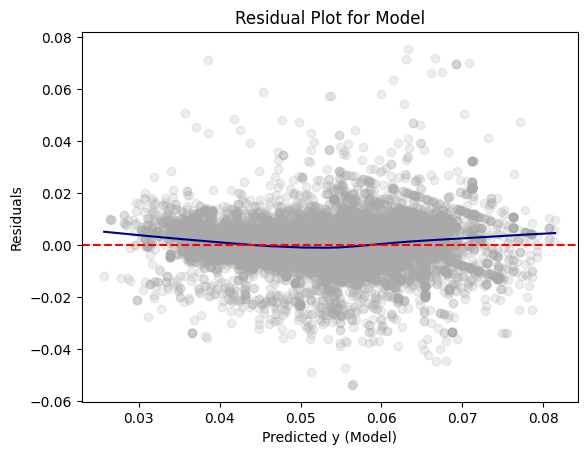

In [ ]:
# Convert test predictions to Pandas
dfpd_1 = dtest_1.select(["prediction", "price_floz"]).toPandas()
dfpd_1["residual"] = dfpd_1["price_floz"] - dfpd_1["prediction"]
plt.scatter(dfpd_1["prediction"], dfpd_1["residual"], alpha=0.2, color="darkgray")

# Use lowess smoothing for the trend line
smoothed = sm.nonparametric.lowess(dfpd_1["residual"], dfpd_1["prediction"])
plt.plot(smoothed[:, 0], smoothed[:, 1], color="darkblue")
plt.axhline(y=0, color="red", linestyle="--")
plt.xlabel("Predicted y (Model)")
plt.ylabel("Residuals")
plt.title("Residual Plot for Model")
plt.show()

On the residual plot for Model 1, the residuals are centered around zero, meaning that on average, the predictions are correct. However, the plot shows some curvature, suggesting that there may be some systematic errors.

#### Model 2

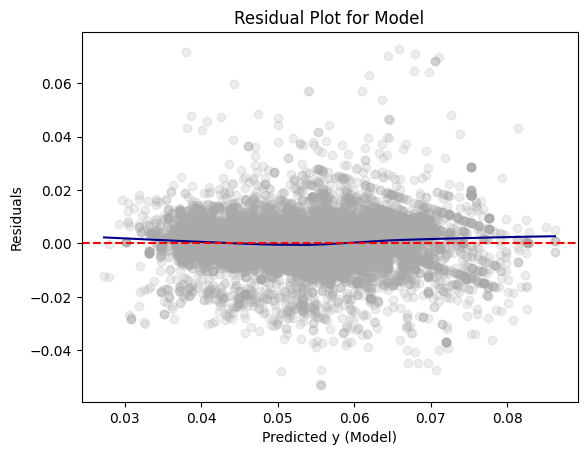

In [ ]:
# Convert test predictions to Pandas
dfpd_2 = dtest_2.select(["prediction", "price_floz"]).toPandas()
dfpd_2["residual"] = dfpd_2["price_floz"] - dfpd_2["prediction"]
plt.scatter(dfpd_2["prediction"], dfpd_2["residual"], alpha=0.2, color="darkgray")

# Use lowess smoothing for the trend line
smoothed = sm.nonparametric.lowess(dfpd_2["residual"], dfpd_2["prediction"])
plt.plot(smoothed[:, 0], smoothed[:, 1], color="darkblue")
plt.axhline(y=0, color="red", linestyle="--")
plt.xlabel("Predicted y (Model)")
plt.ylabel("Residuals")
plt.title("Residual Plot for Model")
plt.show()

For Model 2, the residuals are centered around 0, like Model 1. This indicates that the model's predictions are correct on average. The plot is curved but has less curvature than Model 1, showing that it may have less systematic errors.

#### Model 3

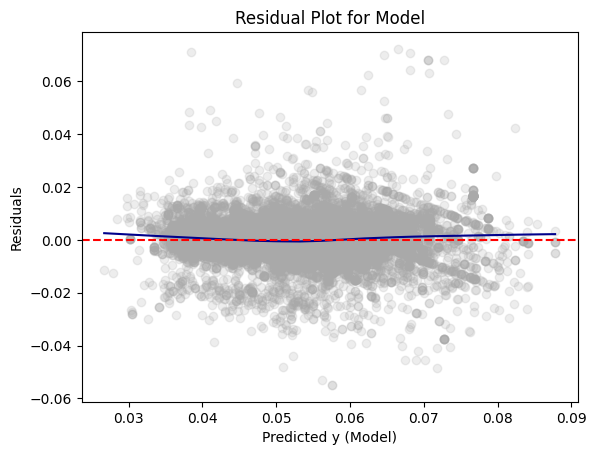

In [ ]:
# Convert test predictions to Pandas
dfpd_3 = dtest_3.select(["prediction", "price_floz"]).toPandas()
dfpd_3["residual"] = dfpd_3["price_floz"] - dfpd_3["prediction"]
plt.scatter(dfpd_3["prediction"], dfpd_3["residual"], alpha=0.2, color="darkgray")

# Use lowess smoothing for the trend line
smoothed = sm.nonparametric.lowess(dfpd_3["residual"], dfpd_3["prediction"])
plt.plot(smoothed[:, 0], smoothed[:, 1], color="darkblue")
plt.axhline(y=0, color="red", linestyle="--")
plt.xlabel("Predicted y (Model)")
plt.ylabel("Residuals")
plt.title("Residual Plot for Model")
plt.show()

Like Models 1 and 2, the residuals for Model 3 are centered around 0. This shows that the model's predictions are correct on average. The plot is slightly curved but has less curvature than Models 1 and 2, showing that it may have less systematic errors.

## Conclusion

I prefer Model 3 because its residual plot shows the least amount of possible systematic errors with the predictions still being correct on average. However, the beta values for the beer markets are very close to 0, meaning that the market has little impact on the dependent variable. The market variable could be removed from this model and a different variable could be tested in its place.